# Welcome to the tutorial about mypackage!

In [53]:
pip list

Package            Version      Editable project location
------------------ ------------ ---------------------------------------------------------
anyio              4.9.0
asttokens          2.4.1
attrs              25.1.0
beautifulsoup4     4.12.3
Brotli             1.1.0
build              1.2.2.post1
CacheControl       0.14.2
certifi            2024.8.30
cffi               1.17.1
charset-normalizer 3.4.0
cleo               2.1.0
colorama           0.4.6
comm               0.2.2
contourpy          1.3.0
crashtest          0.4.1
cycler             0.12.1
debugpy            1.8.9
decorator          5.1.1
distlib            0.3.9
dulwich            0.22.8
executing          2.1.0
fastjsonschema     2.21.1
filelock           3.18.0
findpython         0.6.3
fonttools          4.54.1
h11                0.14.0
httpcore           1.0.7
httpx              0.28.1
idna               3.10
installer          0.7.0
ipykernel          6.29.5
ipython            8.29.0
jaraco.classes     3.4.0
jarac

In [54]:
from pygroupf.data_processing import DataProcessor

In [55]:
# Define column types
categorical_cols = [
    "Sex",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
]
numerical_cols = ["Age", "Job", "Credit amount", "Duration"]

"""
Encode specific categorical columns with numerical values as per requirements:
- sex: male=1, female=0
- housing: own=2, free=1, rent=0
- saving_accounts: unknown=0, little=1, moderate=2, quite rich=3, rich=4
- checking_account: unknown=0, little=1, moderate=2, rich=3
"""

# Define mapping of categorical values to numerical values
mapping = {
    "Sex": {"male": 1, "female": 0, "unknown": -1},
    "Housing": {"own": 2, "free": 1, "rent": 0, "unknown": -1},
    "Saving accounts": {
        "unknown": 0,
        "little": 1,
        "moderate": 2,
        "quite rich": 3,
        "rich": 4,
    },
    "Checking account": {"unknown": 0, "little": 1, "moderate": 2, "rich": 3},
}

In [56]:
# data processing
processor = DataProcessor("data/german_credit_data.csv")
processor.load_data()
processor.clean_data(categorical_cols, numerical_cols)
processor.encode_categorical_values(mapping)
processed_data = processor.get_processed_data()

Data processing completed successfully!


In [57]:
# Display the processed data
processed_data.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,1,2,2,0,1,1169,6,radio/TV
1,22,0,2,2,1,2,5951,48,radio/TV
2,49,1,1,2,1,0,2096,12,education
3,45,1,2,1,1,1,7882,42,furniture/equipment
4,53,1,2,1,1,1,4870,24,car


## Credit Risk Modeling with Random Forest
### Loading Processed Data
    by loading the pre-processed credit data that has gone through cleaning


In [58]:
# Import all modeling functions
import pandas as pd
from pygroupf.modeling import *

# Load processed data
data = pd.read_csv("data/processed_credit_data.csv")
print("Data shape:", data.shape)
data.head()

Data shape: (1000, 9)


,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,1,2,2,0,1,1169,6,radio/TV
1,22,0,2,2,1,2,5951,48,radio/TV
2,49,1,1,2,1,0,2096,12,education
3,45,1,2,1,1,1,7882,42,furniture/equipment
4,53,1,2,1,1,1,4870,24,car


### Feature Engineering
    need to:
        1.Encode categorical variables using one-hot encoding
        2.Create our target variable ('good_credit')

In [59]:
# One-Hot Encoding for categorical features
categorical_cols = ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Create binary target variable
# Good credit = customers with credit > 10,000 and age > 30
data['good_credit'] = ((data['credit_amount'] > 10000) & (data['age'] > 30)).astype(int)
print("Class distribution:\n", data['good_credit'].value_counts())

Class distribution:
 good_credit
0    975
1     25
Name: count, dtype: int64


### Model Training
#### Train-Test Split
    We split the data into 80% training and 20% test sets.

In [60]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop(columns=['good_credit'])
y = data['good_credit']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 800, Test samples: 200


#### Hyperparameter Tuning
    We use GridSearchCV to find the optimal Random Forest parameters.

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Parameter grid for tuning
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "n_estimators": [3, 5, 10, 25, 50, 150],
    "max_features": [4, 7, 15, 20]
}

# Initialize and fit GridSearch
rf = RandomForestClassifier(random_state=2)
grid_search = GridSearchCV(
    rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='recall', 
    verbose=1
)
grid_search.fit(X_train, y_train)

# Show best parameters
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'max_depth': 3, 'max_features': 15, 'n_estimators': 25}
Best recall score: 0.9199999999999999


### Model Evaluation
#### Training Final Model
    We train the final model using the best parameters found.

In [62]:
# Train model with optimal parameters
best_rf = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=2
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=15, n_estimators=25,
                       random_state=2)

#### Performance Metrics
    We evaluate on the test set using:Accuracy, Confusion Matrix, F2 Score (giving more weight to recall)

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score

# Make predictions
y_pred = best_rf.predict(X_test)

# Calculate metrics
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))

Test Set Performance:
Accuracy: 1.0
Confusion Matrix:
 [[198   0]
 [  0   2]]
F2 Score: 1.0


### Feature Importance
    to understand which features most impact predictions.

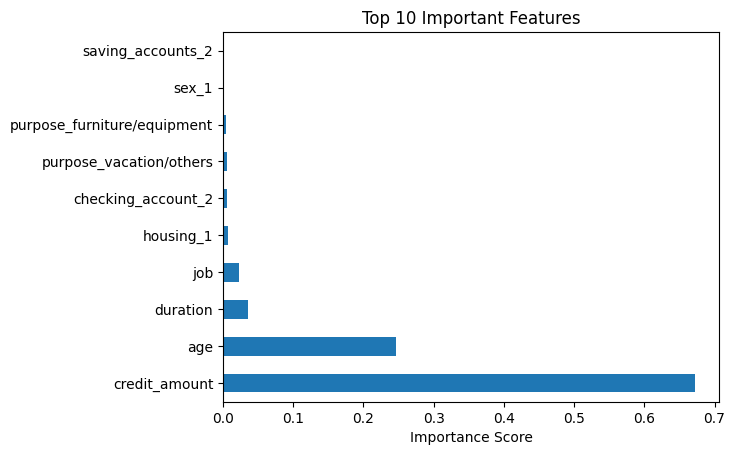

In [64]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot top 10 features
feat_imp[:10].plot(kind='barh')
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.show()

## Analysis

In [65]:
from pygroupf.analysis import DataAnalyzer

In [66]:
# Define scoring rules for different fields
scoring_rules = {
    'Age': [
        {'condition': lambda x: x < 20 or x > 70, 'score': 15},
        {'condition': lambda x: 20 <= x < 25 or 60 < x <= 70, 'score': 10},
        {'condition': lambda x: 25 <= x < 30 or 50 < x <= 60, 'score': 5}
    ],
    'Sex': {'male': 2, 'female': 0, 'unknown': 1},
    'Job': {0: 15, 1: 10, 2: 5, 3: 1},
    'Housing': {0: 15, 1: 10, 2: 5},
    'Saving accounts': {
        'default': lambda x: (4 - x) * 3 if x > 0 else 10,
        'specific': {0: 10}
    },
    'Checking account': {
        'default': lambda x: (3 - x) * 4 if x > 0 else 10,
        'specific': {0: 10}
    },
    'Credit amount': [
        {'threshold': 8000, 'score': 15},
        {'threshold': 5000, 'score': 10},
        {'threshold': 2000, 'score': 5}
    ],
    'Duration': [
        {'threshold': 36, 'score': 15},
        {'threshold': 24, 'score': 10},
        {'threshold': 12, 'score': 5}
    ],
    'Purpose': {
        'business': 10,
        'education': 10,
        'unknown': 8,
        'car': 5,
        'furniture/equipment': 5,
        'radio/TV': 3,
        'domestic appliances': 3,
        'repairs': 3,
        'vacation/others': 3
    }
}

# Define risk levels based on total score
risk_levels = [
    (70, "High risk"),
    (50, "Medium-high risk"),
    (30, "Medium-low risk"),
    (0, "Low risk")
]

In [67]:
# data analysis and save risk report
# processed_data = pd.read_csv("data/processed_credit_data.csv")
analyzer = DataAnalyzer(processed_data, scoring_rules, risk_levels)
risk_report = analyzer.generate_risk_report() 
analyzer.save_risk_report("data/risk_report.csv")

Risk report saved to data/risk_report.csv


In [68]:
# Display the risk report
risk_report.head()

,customer_id,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk_score,risk_level
0,1,67,1,2,2,0,1,1169,6,radio/TV,41,Medium-low risk
1,2,22,0,2,2,1,2,5951,48,radio/TV,61,Medium-high risk
2,3,49,1,1,2,1,0,2096,12,education,49,Medium-low risk
3,4,45,1,2,1,1,1,7882,42,furniture/equipment,62,Medium-high risk
4,5,53,1,2,1,1,1,4870,24,car,52,Medium-high risk


In [69]:
from pygroupf.visualization import DataVisualizer

In [70]:
visualizer = DataVisualizer('data/risk_report.csv')
visualizer.visualize_all()

Heatmap saved to image/heatmap.png
Risk level distribution plot saved to image/risk_distribution.png
All visualizations have been generated and saved to the 'image' folder.
